In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [2]:
import pandas as pd
import csv
import numpy as np
import torch
import torch.nn as nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
covidData=pd.read_csv('/content/drive/MyDrive/Data Dissertation/FinalCleansedCovidData.csv')

In [5]:
covidData.head()

,Text,Label,Source
0,0 1g resolution weighing scale for my laborato...,1,Twitter
1,0 5 death rate is the same number that iceland...,1,Twitter
2,0 belonging to adivasi or tribal communities,1,Twitter
3,0 testing,1,Twitter
4,00 heaven james bond legend sean connery dies ...,1,Twitter


In [6]:
print("Count of data in the dataframe:",len(covidData))

Count of data in the dataframe: 101287


In [7]:
covidData['Label'].value_counts()

1    75103
0    26184
Name: Label, dtype: int64

In [8]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.7 MB/s eta 0:00:00


In [9]:
from transformers import RobertaForSequenceClassification,RobertaTokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [10]:
sentences = covidData['Text'].values
labels = covidData['Label'].values

In [11]:
print(' Original Text: ', sentences[0])
print('Tokenized: ', roberta_tokenizer.tokenize(sentences[0]))
print('Token IDs: ', roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.tokenize(sentences[0])))

 Original Text:  0 1g resolution weighing scale for my laboratory maximum capacity 2kgs nice
Tokenized:  ['0', 'Ġ1', 'g', 'Ġresolution', 'Ġweighing', 'Ġscale', 'Ġfor', 'Ġmy', 'Ġlaboratory', 'Ġmaximum', 'Ġcapacity', 'Ġ2', 'kg', 's', 'Ġnice']
Token IDs:  [288, 112, 571, 3547, 11003, 3189, 13, 127, 13154, 4532, 2148, 132, 9043, 29, 2579]


In [12]:
robert_input_ids = []
robert_attention_masks = []
sentence_ids = []
counter = 0

for sentence in sentences:
    robert_encoded_dict = roberta_tokenizer.encode_plus(
                        str(sentence),
                        add_special_tokens = True,
                        max_length = 150,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True,
                   )
    robert_input_ids.append(robert_encoded_dict['input_ids'])
    robert_attention_masks.append(robert_encoded_dict['attention_mask'])

    sentence_ids.append(counter)
    counter  = counter + 1




robert_input_ids = torch.cat(robert_input_ids, dim=0)
robert_attention_masks = torch.cat(robert_attention_masks, dim=0)

labels = torch.tensor(labels)
sentence_ids = torch.tensor(sentence_ids)


print('Original data IDs: ', sentences[1])
print('Token IDs BERT:', robert_input_ids[1])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original data IDs:  0 5 death rate is the same number that iceland and germany also produced in their antibody tes
Token IDs BERT: tensor([    0,   288,   195,   744,   731,    16,     5,   276,   346,    14,
        41591,  9999,     8,   821,  7043,   219,    67,  2622,    11,    49,
        34517,   326,   293,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
           

In [13]:
from torch.utils.data import TensorDataset, random_split

# Add data to TensorDataset.
robert_covid_dataset = TensorDataset(robert_input_ids, robert_attention_masks, labels)
print(len(robert_covid_dataset))

101287


In [14]:

train_size = int(0.7 * len(robert_covid_dataset))
val_size = int(0.1 * len(robert_covid_dataset))
test_size = len(robert_covid_dataset) - train_size - val_size

robert_train_dataset, robert_val_dataset, robert_test_dataset = random_split(
    robert_covid_dataset, [train_size, val_size, test_size]
)

In [15]:
example_text = roberta_tokenizer.decode(robert_input_ids[0])
example_text

'<s>0 1g resolution weighing scale for my laboratory maximum capacity 2kgs nice</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [16]:
label_temp_list = []
for a,b,c in robert_train_dataset:
  label_temp_list.append(c)

print('count of training data',train_size)
print('count of training with real covid data',int(sum(label_temp_list)))


label_temp_list = []
for a,b,c in robert_val_dataset:
  label_temp_list.append(c)

print('count of validation data',val_size)
print('count of validation data with real covid data',int(sum(label_temp_list)))

count of training data 70900
count of training with real covid data 52649
count of validation data 10128
count of validation data with real covid data 7505


In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
robert_train_dataloader = DataLoader(
            robert_train_dataset,
            sampler = RandomSampler(robert_train_dataset),
            batch_size = batch_size
        )
robert_validation_dataloader = DataLoader(
            robert_val_dataset,
            sampler = SequentialSampler(robert_val_dataset),
            batch_size = batch_size
        )

robert_test_dataloader = DataLoader(
            robert_test_dataset,
            sampler = SequentialSampler(robert_test_dataset),
            batch_size = batch_size
        )

In [18]:
from transformers import (RobertaConfig,RobertaForSequenceClassification,AdamW)

In [19]:
num_labels=2
model_name = 'roberta-base'
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Add a dropout layer
dropout_prob = 0.3  # Set the dropout probability as desired

# Replace the classifier layer with a dropout layer
model_config = model.config
model_config.hidden_dropout_prob = dropout_prob

classifier_dropout_layer = nn.Dropout(dropout_prob)
model.classifier.dropout = classifier_dropout_layer

# Define your custom classifier with an additional LSTM layer
class CustomClassifierWithLSTM(nn.Module):
    def __init__(self, base_model, num_labels, lstm_hidden_size=128, lstm_num_layers=1):
        super(CustomClassifierWithLSTM, self).__init__()
        self.base_model = base_model
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(lstm_hidden_size * 2, num_labels)  # Multiply by 2 for bidirectional LSTM

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # Get the sequence output
        lstm_output, _ = self.lstm(sequence_output)
        lstm_output = lstm_output[:, -1, :]  # Take the output of the last timestep
        logits = self.linear(lstm_output)

        return logits

# Instantiate the custom classifier with LSTM
custom_classifier_with_lstm = CustomClassifierWithLSTM(model, num_labels)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_classifier_with_lstm.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomClassifierWithLSTM(
  (base_model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
         

In [ ]:
#no dropout
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
#Dropout 0.2
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Add a dropout layer
dropout_prob = 0.2  # Set the dropout probability as desired

# Replace the classifier layer with a dropout layer
model_config = model.config
model_config.hidden_dropout_prob = dropout_prob

classifier_dropout_layer = nn.Dropout(dropout_prob)
model.classifier.dropout = classifier_dropout_layer

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
#Dropout 0.3
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Add a dropout layer
dropout_prob = 0.3  # Set the dropout probability as desired

# Replace the classifier layer with a dropout layer
model_config = model.config
model_config.hidden_dropout_prob = dropout_prob

classifier_dropout_layer = nn.Dropout(dropout_prob)
model.classifier.dropout = classifier_dropout_layer

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
#Dropout 0.4
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Add a dropout layer
dropout_prob = 0.4  # Set the dropout probability as desired

# Replace the classifier layer with a dropout layer
model_config = model.config
model_config.hidden_dropout_prob = dropout_prob

classifier_dropout_layer = nn.Dropout(dropout_prob)
model.classifier.dropout = classifier_dropout_layer

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
robert_optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5
                  weight_decay=0.01,
                 correct_bias=False
                )

In [20]:
robert_optimizer = AdamW(custom_classifier_with_lstm.parameters(),
                  lr = 2e-5, # default is 5e-5
                  weight_decay=0.01,
                 correct_bias=False
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
#Calculate the performance metrics
def truePositive(predictions, labels):
  return sum([predictions == labels and predictions == 1 for predictions, labels in zip(predictions, labels)])

def trueNegative(predictions, labels):
  return sum([predictions == labels and predictions == 0 for predictions, labels in zip(predictions, labels)])

def falsePositive(predictions, labels):
  return sum([predictions != labels and predictions == 1 for predictions, labels in zip(predictions, labels)])

def falseNegative(predictions, labels):
  return sum([predictions != labels and predictions == 0 for predictions, labels in zip(predictions, labels)])

def metrics(predictions, labels):
  predictions = np.argmax(predictions, axis = 1).flatten()
  labels = labels.flatten()
  tp = truePositive(predictions, labels)
  tn = trueNegative(predictions, labels)
  fp = falsePositive(predictions, labels)
  fn = falseNegative(predictions, labels)
  accuracy = (tp + tn) / len(labels)
  precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return accuracy, precision, recall, specificity

In [ ]:
from tqdm import trange
from sklearn.metrics import precision_recall_fscore_support
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Tracking variables
    train_accuracy = []
    train_precision = []
    train_recall = []
    train_specificity = []
    train_f1 = []

    for step, batch in enumerate(robert_train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        robert_optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids,
                             token_type_ids = None,
                             attention_mask = b_input_mask,
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        robert_optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        train_logits = train_output.logits.detach().cpu().numpy()
        train_label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        t_accuracy, t_precision, t_recall, t_specificity = metrics(train_logits, train_label_ids)
        train_accuracy.append(t_accuracy)

        if t_precision != 'nan': train_precision.append(t_precision)
        if t_recall != 'nan': train_recall.append(t_recall)
        if t_specificity != 'nan': train_specificity.append(t_specificity)
        t_f1 = precision_recall_fscore_support(train_label_ids, np.argmax(train_logits, axis=1), average='weighted')[2]
        train_f1.append(t_f1)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Training Accuracy: {:.4f}'.format(sum(train_accuracy)/len(train_accuracy)))
    print('\t - Training Precision: {:.4f}'.format(sum(train_precision)/len(train_precision)) if len(train_precision)>0 else '\t - Training Precision: NaN')
    print('\t - Training Recall: {:.4f}'.format(sum(train_recall)/len(train_recall)) if len(train_recall)>0 else '\t - Training Recall: NaN')
    print('\t - Training Specificity: {:.4f}\n'.format(sum(train_specificity)/len(train_specificity)) if len(train_specificity)>0 else '\t - Training Specificity: NaN')
    print('\t - Training F1 Score: {:.4f}'.format(sum(train_f1) / len(train_f1)) if len(train_f1) > 0 else '\t - Training F1 Score: NaN')

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []
    val_f1 = []

    for batch in robert_validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask)
        val_logits = eval_output.logits.detach().cpu().numpy()
        val_label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        v_accuracy, v_precision, v_recall, v_specificity = metrics(val_logits, val_label_ids)
        val_accuracy.append(v_accuracy)
        if v_precision != 'nan': val_precision.append(v_precision)
        if v_recall != 'nan': val_recall.append(v_recall)
        if v_specificity != 'nan': val_specificity.append(v_specificity)
        v_f1 = precision_recall_fscore_support(val_label_ids, np.argmax(val_logits, axis=1), average='weighted')[2]
        val_f1.append(v_f1)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')
    print('\t - Validation F1 Score: {:.4f}'.format(sum(val_f1) / len(val_f1)) if len(val_f1) > 0 else '\t - Validation F1 Score: NaN')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/pytho


	 - Train loss: 0.2254
	 - Training Accuracy: 0.9095
	 - Training Precision: 0.9252
	 - Training Recall: 0.9592
	 - Training Specificity: 0.7706

	 - Training F1 Score: 0.9023


Epoch:  50%|█████     | 1/2 [07:40<07:40, 460.07s/it]


	 - Train loss: 0.2254
	 - Validation Accuracy: 0.9519
	 - Validation Precision: 0.9736
	 - Validation Recall: 0.9620
	 - Validation Specificity: 0.9184

	 - Validation F1 Score: 0.9523

	 - Train loss: 0.1147
	 - Training Accuracy: 0.9602
	 - Training Precision: 0.9669
	 - Training Recall: 0.9800
	 - Training Specificity: 0.9038

	 - Training F1 Score: 0.9597


Epoch: 100%|██████████| 2/2 [15:19<00:00, 459.97s/it]


	 - Train loss: 0.1147
	 - Validation Accuracy: 0.9618
	 - Validation Precision: 0.9678
	 - Validation Recall: 0.9819
	 - Validation Specificity: 0.8996

	 - Validation F1 Score: 0.9612


In [22]:
from tqdm import trange
from sklearn.metrics import precision_recall_fscore_support
epochs = 2
criterion = nn.CrossEntropyLoss()
for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Tracking variables
    train_accuracy = []
    train_precision = []
    train_recall = []
    train_specificity = []
    train_f1 = []

    for step, batch in enumerate(robert_train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        robert_optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids,b_input_mask,
                             labels = b_labels)

        # Backward pass
        loss = criterion(train_output.logits, b_labels)
        # Backward pass
        loss.backward()
        robert_optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        train_logits = train_output.logits.detach().cpu().numpy()
        train_label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        t_accuracy, t_precision, t_recall, t_specificity = metrics(train_logits, train_label_ids)
        train_accuracy.append(t_accuracy)

        if t_precision != 'nan': train_precision.append(t_precision)
        if t_recall != 'nan': train_recall.append(t_recall)
        if t_specificity != 'nan': train_specificity.append(t_specificity)
        t_f1 = precision_recall_fscore_support(train_label_ids, np.argmax(train_logits, axis=1), average='weighted')[2]
        train_f1.append(t_f1)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Training Accuracy: {:.4f}'.format(sum(train_accuracy)/len(train_accuracy)))
    print('\t - Training Precision: {:.4f}'.format(sum(train_precision)/len(train_precision)) if len(train_precision)>0 else '\t - Training Precision: NaN')
    print('\t - Training Recall: {:.4f}'.format(sum(train_recall)/len(train_recall)) if len(train_recall)>0 else '\t - Training Recall: NaN')
    print('\t - Training Specificity: {:.4f}\n'.format(sum(train_specificity)/len(train_specificity)) if len(train_specificity)>0 else '\t - Training Specificity: NaN')
    print('\t - Training F1 Score: {:.4f}'.format(sum(train_f1) / len(train_f1)) if len(train_f1) > 0 else '\t - Training F1 Score: NaN')

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []
    val_f1 = []

    for batch in robert_validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids,b_input_mask)
        val_logits = eval_output.logits.detach().cpu().numpy()
        val_label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        v_accuracy, v_precision, v_recall, v_specificity = metrics(val_logits, val_label_ids)
        val_accuracy.append(v_accuracy)
        if v_precision != 'nan': val_precision.append(v_precision)
        if v_recall != 'nan': val_recall.append(v_recall)
        if v_specificity != 'nan': val_specificity.append(v_specificity)
        v_f1 = precision_recall_fscore_support(val_label_ids, np.argmax(val_logits, axis=1), average='weighted')[2]
        val_f1.append(v_f1)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')
    print('\t - Validation F1 Score: {:.4f}'.format(sum(val_f1) / len(val_f1)) if len(val_f1) > 0 else '\t - Validation F1 Score: NaN')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/pytho


	 - Train loss: 0.1622
	 - Training Accuracy: 0.9388
	 - Training Precision: 0.9485
	 - Training Recall: 0.9718
	 - Training Specificity: 0.8442

	 - Training F1 Score: 0.9364


Epoch:  50%|█████     | 1/2 [09:19<09:19, 560.00s/it]


	 - Train loss: 0.1622
	 - Validation Accuracy: 0.9649
	 - Validation Precision: 0.9757
	 - Validation Recall: 0.9774
	 - Validation Specificity: 0.9287

	 - Validation F1 Score: 0.9648

	 - Train loss: 0.0882
	 - Training Accuracy: 0.9683
	 - Training Precision: 0.9736
	 - Training Recall: 0.9842
	 - Training Specificity: 0.9217

	 - Training F1 Score: 0.9680


Epoch: 100%|██████████| 2/2 [18:39<00:00, 559.94s/it]


	 - Train loss: 0.0882
	 - Validation Accuracy: 0.9683
	 - Validation Precision: 0.9668
	 - Validation Recall: 0.9914
	 - Validation Specificity: 0.9000

	 - Validation F1 Score: 0.9674


In [23]:
predicted_labels = []
for batch in robert_test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_attention_mask = batch[1].to(device)

    with torch.no_grad():
        batch_logits = model(batch_input_ids, batch_attention_mask).logits
        batch_probabilities = torch.softmax(batch_logits, dim=1)
        batch_predicted_classes = torch.argmax(batch_probabilities, dim=1)
        predicted_labels.extend(batch_predicted_classes.cpu().tolist())

print(predicted_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 

In [24]:
# Obtain the ground truth labels
ground_truth_labels = [sample[2] for sample in robert_test_dataset]

# Calculate the number of correct predictions
correct_predictions = sum(predicted_label == ground_truth_label for predicted_label, ground_truth_label in zip(predicted_labels, ground_truth_labels))

# Calculate the total number of predictions
total_predictions = len(ground_truth_labels)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Calculate true positives, true negatives, false positives, false negatives
true_positives = sum((predicted_label == 1) and (ground_truth_label == 1) for predicted_label, ground_truth_label in zip(predicted_labels, ground_truth_labels))
print('TP: ',true_positives)
true_negatives = sum((predicted_label == 0) and (ground_truth_label == 0) for predicted_label, ground_truth_label in zip(predicted_labels, ground_truth_labels))
print('TN: ',true_negatives)
false_positives = sum((predicted_label == 1) and (ground_truth_label == 0) for predicted_label, ground_truth_label in zip(predicted_labels, ground_truth_labels))
print('FP: ',false_positives)
false_negatives = sum((predicted_label == 0) and (ground_truth_label == 1) for predicted_label, ground_truth_label in zip(predicted_labels, ground_truth_labels))
print('FN: ',false_negatives)

# Calculate precision
precision = true_positives / (true_positives + false_positives)

# Calculate recall (sensitivity)
recall = true_positives / (true_positives + false_negatives)

# Calculate specificity
specificity = true_negatives / (true_negatives + false_positives)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)
# Print the F1 score
print("F1 Score:", f1_score)

TP:  tensor(14825)
TN:  tensor(4698)
FP:  tensor(612)
FN:  tensor(124)
Accuracy: tensor(0.9637)
Precision: tensor(0.9604)
Recall: tensor(0.9917)
Specificity: tensor(0.8847)
F1 Score: tensor(0.9758)


In [25]:
test_predicted_probabilities = []
model.eval()
for batch in robert_test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_attention_mask = batch[1].to(device)

    with torch.no_grad():
        logits = model(batch_input_ids, batch_attention_mask).logits
        probabilities = torch.softmax(logits, dim=1)

    # Extract the probabilities for the positive class (assuming binary classification)
    positive_probabilities = probabilities[:, 1]

    # Append the probabilities to the list
    test_predicted_probabilities.extend(positive_probabilities.to(device).tolist())

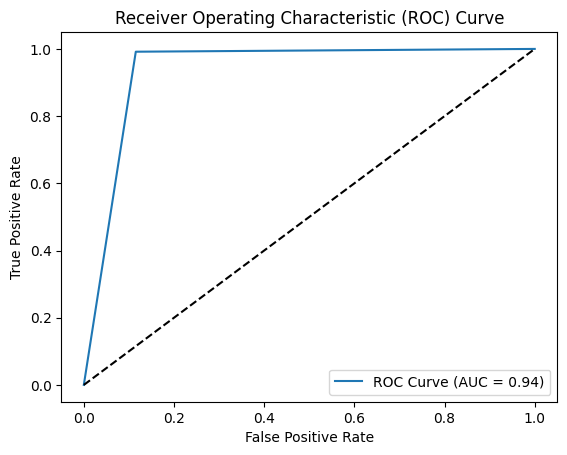

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(ground_truth_labels, predicted_labels)

# Calculate the AUC score
auc_score = roc_auc_score(ground_truth_labels, predicted_labels)



# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
print(auc_score)

0.9382254467449215


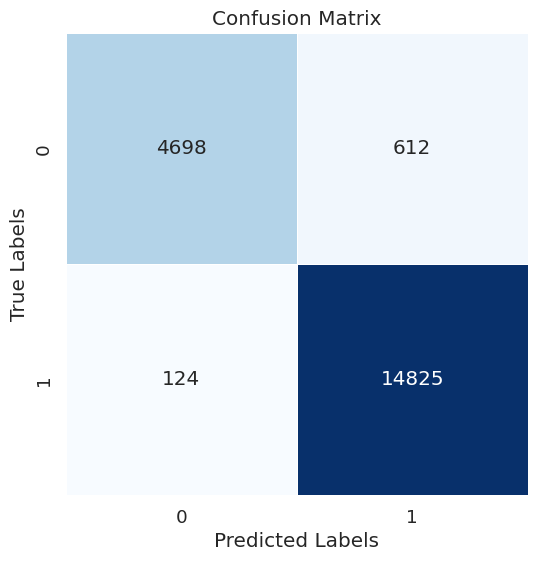

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False, square=True, linewidths=.5)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()